In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
import random
import time

tf.compat.v1.disable_eager_execution()

/Users/ggraham/anaconda3/envs/vae/lib/python3.7/site-packages/scipy/__init__.py:149: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.0
  UserWarning)


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from data_loader import DataGenerator
from models import VAEmodel, lstmKerasModel
from trainers import vaeTrainer

from utils import process_config, create_dirs, get_args

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

[]


2022-01-04 13:22:01.882673: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-01-04 13:22:01.897429: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8612770910 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-04 13:22:01.897450: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
conv_1: Tensor("encoder/conv2d/LeakyRelu:0", shape=(?, 24, 1, 32), dtype=float32)
conv_2: Tensor("encoder/conv2d_1/LeakyRelu:0", shape=(?, 12, 1, 64), dtype=float32)
conv_3: Tensor("encoder/conv2d_2/LeakyRelu:0", shape=(?, 6, 1, 128), dtype=float32)
conv_4: Tensor("encoder/conv2d_3/LeakyRelu:0", shape=(?, 1, 1, 512), dtype=float32)
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
finish encoder: 
Tensor("encoder/MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0", shape=(?, 6), dtype=float32)


decoded_2 is: Tensor("decoder/Reshape_1:0", shape=(?, 3, 1, 256), dtype=float32)
decoded_3 

2022-01-04 13:22:15.938142: I tensorflow/core/common_runtime/placer.cc:54] global_step/global_step: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:15.938160: I tensorflow/core/common_runtime/placer.cc:54] global_step/global_step/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:15.938164: I tensorflow/core/common_runtime/placer.cc:54] global_step/global_step/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:15.938169: I tensorflow/core/common_runtime/placer.cc:54] global_step/add: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:15.938173: I tensorflow/core/common_runtime/placer.cc:54] global_step/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:15.938176: I tensorflow/core/common_runtime/placer.cc:54] cur_epoch/cur_epoch: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:15.938179: I tensorflow/core/common_runtime/place

checkpoint_dir at loading: ../experiments/local-results/NAB/ambient_temp/batch-32/NAB-ambient_temp-48-12-6-fixedSigma-0.1/checkpoint/
No model loaded.


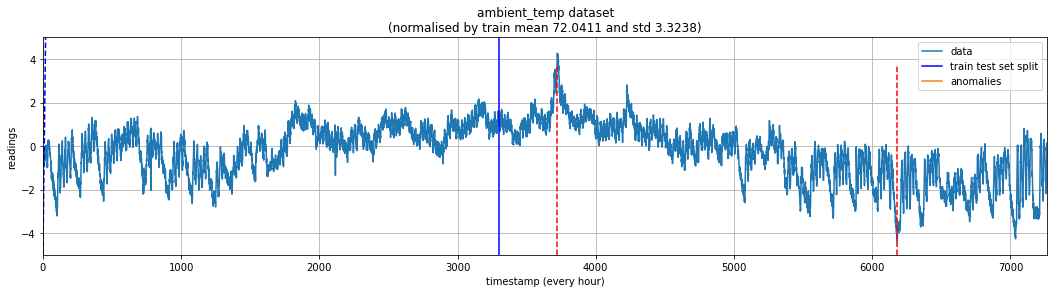

In [5]:
# load VAE model
config = process_config('NAB_config.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir']])
# create tensorflow session
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# create your data generator
data = DataGenerator(config)
# create a CNN model
model_vae = VAEmodel(config)
# create a CNN model
trainer_vae = vaeTrainer(sess, model_vae, data, config)
model_vae.load(sess)

In [6]:
# load LSTM model
lstm_model = lstmKerasModel(data)
lstm_model.produce_embeddings(config, model_vae, data, sess)
lstm_nn_model = lstm_model.create_lstm_model(config)
lstm_nn_model.summary()   # Display the model's architecture

# checkpoint path
checkpoint_path = config['checkpoint_dir_lstm'] + "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# load weights if possible
lstm_model.load_model(lstm_nn_model, config, checkpoint_path)

Finish processing the embeddings of the entire dataset.
The first a few embeddings are
[[-0.03017528  0.00409859  0.01674502  0.02419876 -0.02112313  0.02885665]
 [-0.06124814  0.01243722  0.0503378   0.0441144  -0.0439379   0.05328723]
 [-0.03188872 -0.00502802  0.04121464  0.02634243 -0.03976129  0.05499054]
 [-0.01492752  0.01646166  0.00514578  0.01572689 -0.0057382   0.0024051 ]
 [-0.04005928  0.02774734  0.02929328  0.04564643 -0.02399834  0.01668618]]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 6)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 11, 64)            18176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 11, 64)  

In [7]:
# load normalised time series
save_dir = '../datasets/NAB-known-anomaly/'
dataset = config['dataset']
filename = '{}.npz'.format(dataset)
result = dict(np.load(save_dir+filename, allow_pickle=True))
if dataset == 'machine_temp':
    result['test'] = result['test'][0]
    result['idx_anomaly_test'] = result['idx_anomaly_test'][0]
    result['t_test'] = result['t_test'][0]

# slice into rolling windows and rolling sequences
def slice_rolling_windows_and_sequences(config, time_seq):
    n_sample = len(time_seq)
    print("The given sequence has {} samples".format(n_sample))
    n_vae_win = n_sample - config['l_win'] + 1
    rolling_windows = np.zeros((n_vae_win, config['l_win']))
    for i in range(n_vae_win):
        rolling_windows[i] = time_seq[i:i + config['l_win']]
        sample_m = np.mean(rolling_windows, axis=1)
        sample_std = np.std(rolling_windows, axis=1)

        n_lstm_seq = n_sample - config['l_seq']*config['l_win']+1
        lstm_seq = np.zeros((n_lstm_seq, config['l_seq'], config['l_win']))
    for i in range(n_lstm_seq):
        cur_seq = time_seq[i:i+config['l_seq']*config['l_win']]
        for j in range(config['l_seq']):
            lstm_seq[i,j] = cur_seq[config['l_win']*j:config['l_win']*(j+1)]
    
    return rolling_windows, lstm_seq, sample_m, sample_std

test_windows, test_seq, test_sample_m, test_sample_std = slice_rolling_windows_and_sequences(config, result['test'])
test_windows = np.expand_dims(test_windows, -1)
test_seq = np.expand_dims(test_seq, -1)
print(test_windows.shape)
print(test_seq.shape)

The given sequence has 3967 samples
(3920, 48, 1)
(3392, 12, 48, 1)


In [8]:
# Evaluate ELBO and LSTM prediction error on the validation set
# evaluate some anomaly detection metrics
def evaluate_vae_anomaly_metrics_for_a_window(test_win):
    feed_dict = {model_vae.original_signal: np.expand_dims(test_win, 0),
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}

    # VAE reconstruction error
    recons_win_vae = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict))
    test_vae_recons_error = np.sum(np.square(recons_win_vae - test_win))

    # VAE latent embedding likelihood
    vae_code_mean, vae_code_std = sess.run([model_vae.code_mean, model_vae.code_std_dev], feed_dict=feed_dict)
    test_vae_kl = 0.5 * (np.sum(np.square(vae_code_mean)) + \
                            np.sum(np.square(vae_code_std)) - \
                            np.sum(np.log(np.square(vae_code_std))) - config['code_size'])

    # VAE ELBO loss
    sigma2 = 0.0005
    input_dims = model_vae.input_dims
    sigma_regularisor = input_dims/2. * np.log(sigma2) + input_dims * np.pi
    test_vae_elbo = test_vae_recons_error/sigma2 + test_vae_kl + sigma_regularisor
    return test_vae_recons_error, test_vae_kl, test_vae_elbo

def evaluate_lstm_anomaly_metric_for_a_seq(test_seq):
    feed_dict = {model_vae.original_signal: test_seq,
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}
    vae_embedding = np.squeeze(sess.run(model_vae.code_mean, feed_dict=feed_dict))
    #print(vae_embedding.shape)
    lstm_embedding = np.squeeze(lstm_nn_model.predict(np.expand_dims(vae_embedding[:config['l_seq']-1], 0), batch_size=1))
    lstm_embedding_error = np.sum(np.square(vae_embedding[1:] - lstm_embedding))
    
    # LSTM prediction error
    feed_dict_lstm = {model_vae.original_signal: np.zeros((config['l_seq'] - 1, config['l_win'], 1)),
                      model_vae.is_code_input: True,
                      model_vae.code_input: lstm_embedding}
    recons_win_lstm = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict_lstm))
    lstm_recons_error = np.sum(np.square(recons_win_lstm - np.squeeze(test_seq[1:])))
    return lstm_recons_error, lstm_embedding_error

n_val_vae = data.val_set_vae['data'].shape[0]
n_val_lstm = data.val_set_lstm['data'].shape[0]

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
for i in range(n_val_vae):
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][i])

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
for i in range(n_val_lstm):
    val_lstm_recons_error[i], val_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.val_set_lstm['data'][i])

2022-01-04 13:22:37.145825: I tensorflow/core/common_runtime/placer.cc:54] global_step/global_step: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:37.145847: I tensorflow/core/common_runtime/placer.cc:54] global_step/global_step/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:37.145850: I tensorflow/core/common_runtime/placer.cc:54] global_step/global_step/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:37.145856: I tensorflow/core/common_runtime/placer.cc:54] global_step/add: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:37.145859: I tensorflow/core/common_runtime/placer.cc:54] global_step/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:37.145862: I tensorflow/core/common_runtime/placer.cc:54] cur_epoch/cur_epoch: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:37.145865: I tensorflow/core/common_runtime/place

PU:0
encoder/code_std_dev/bias/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
encoder/code_std_dev/bias/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
decoder/dense/kernel/Adam/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:CPU:0
decoder/dense/kernel/Adam/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
decoder/dense/kernel/Adam_1/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:CPU:0
decoder/dense/kernel/Adam_1/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
decoder/dense/bias/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
decoder/dense/bias/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
decoder/conv2d/kernel/Adam/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:CPU:0
decoder/conv2d/kernel/Adam/In

2022-01-04 13:22:38.157527: I tensorflow/core/common_runtime/placer.cc:54] global_step/global_step: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:38.157546: I tensorflow/core/common_runtime/placer.cc:54] global_step/global_step/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:38.157550: I tensorflow/core/common_runtime/placer.cc:54] global_step/global_step/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:38.157555: I tensorflow/core/common_runtime/placer.cc:54] global_step/add: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:38.157558: I tensorflow/core/common_runtime/placer.cc:54] global_step/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:38.157561: I tensorflow/core/common_runtime/placer.cc:54] cur_epoch/cur_epoch: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
2022-01-04 13:22:38.157564: I tensorflow/core/common_runtime/place

m_2_target: (Placeholder): /job:localhost/replica:0/task:0/device:CPU:0
total/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
total: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
count_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
count_1: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
metrics/mean_squared_error/Mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
metrics/mean_squared_error/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
loss_1/lstm_2_loss/Mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:CPU:0
loss_1/lstm_2_loss/weighted_loss/Cast/x: (Const): /job:localhost/replica:0/task:0/device:CPU:0
loss_1/lstm_2_loss/weighted_loss/broadcast_weights/assert_broadcastable/weights/shape: (Const): /job:localhost/replica:0/task:0/device:CPU:0
loss_1/lstm_2_loss/weighted_loss/broadcast_weights/assert_broadcastable/weights/rank: (Const): /job:localh

In [9]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None, saveplot=False):
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    if saveplot:
        savefig(config['result_dir']+'reconstruction_error_histogram.pdf')
    else:
        plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold_1))
#     print(his[0][-20:])
#     print(his[1][-20:])
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
#     print("Median: {}".format(np.median(test_anomaly_list)))
#     print("Mean: {}".format(np.mean(test_anomaly_list)))
#     print("Std dev: {}".format(np.std(test_anomaly_list)))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

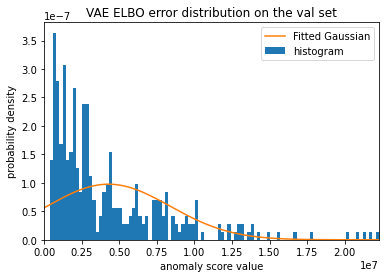

25% percentile: 1323126.56352492
75% percentile: 6105408.744598278
These windows scored the top 1% of anomaly metric (20631796.49279045): 
[ 8  9 10 11]


In [10]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

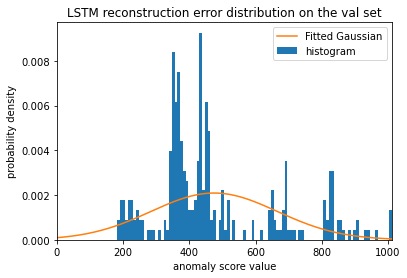

25% percentile: 356.19317924739823
75% percentile: 533.9563819375433
These windows scored the top 1% of anomaly metric (976.8672148576208): 
[53 70 90]


In [11]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m, lstm_recons_std = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [12]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
for i in range(n_test_lstm):
    test_lstm_recons_error[i], test_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

All windows' reconstruction error is computed.
The total number of windows is 3392


25% percentile: 434.49758410173365
75% percentile: 1865.1473328131187
These windows scored the top 1% of anomaly metric (2322.1042798940284): 
[2797 2798 2799 2800 2801 2802 2803 2804 2805 2806 2807 2808 2809 2810
 2811 2812 2813 2814 2815 2816 2817 2818 2819 2820 2821 2822 2823 2824
 2825 2826 2827 2828 2829 2830]


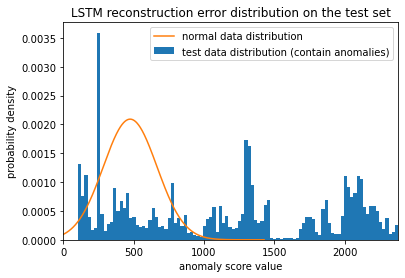

In [13]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m, std=lstm_recons_std, xlim=None, saveplot=True)

In [14]:
# Produce the ground truth anomaly indices 
# if result['idx_split'][0] == 0:
#     idx_anomaly_test = result['idx_anomaly_test']
# else:
#     idx_anomaly_test = result['idx_anomaly_test'][0]
idx_anomaly_test = result['idx_anomaly_test']    
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in range(len(idx_anomaly_test)):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    idx_end = idx_anomaly_test[i]+1
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

(3392,)


In [15]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    test_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    idx_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold))
    
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    
    return list(idx_error)

In [16]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    n_anomaly = len(anomaly_index)
    idx_detected_anomaly_extended = list(idx_detected_anomaly)
    for i in range(n_anomaly):
        #print(idx_detected_anomaly)
        for j in idx_detected_anomaly:
            if j in anomaly_index[i]:
                in_original_detection = set(idx_detected_anomaly_extended)
                currect_anomaly_win = set(anomaly_index[i])
                idx_detected_anomaly_extended = idx_detected_anomaly_extended + list(currect_anomaly_win - in_original_detection)
                #print(j)
                break
                
    return list(np.sort(idx_detected_anomaly_extended))

In [17]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP = 0
    n_FP = 0
    n_detection = len(idx_detected_anomaly)
    for i in range(n_detection):
        if test_labels[idx_detected_anomaly[i]] == 1:
            n_TP = n_TP + 1
        else:
            n_FP = n_FP + 1
    
    idx_undetected = list(set(np.arange(len(test_labels)))- set(idx_detected_anomaly))
    n_FN = 0
    for i in idx_undetected:
        if test_labels[i] == 1:
            n_FN = n_FN + 1
    
    return n_TP, n_FP, n_FN

In [18]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    # compute true positive
    n_TP, n_FP, n_FN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)
    
    if n_TP + n_FP == 0:
        precision = 1
    else:
        precision = n_TP / (n_TP + n_FP)
    recall = n_TP / (n_TP + n_FN)
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2* (precision * recall)/(precision + recall)
    
    return precision, recall, F1, n_TP, n_FP, n_FN

In [19]:
n_threshold = 200
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
i = 0
threshold_list = np.linspace(np.amin(test_lstm_recons_error), np.amax(test_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in threshold_list:
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
    precision[i], recall[i], F1[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           anomaly_index_lstm, 
                                                                           test_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_lstm_augmented = augment_detected_idx(idx_detection_lstm, anomaly_index_lstm)
    precision_aug[i], recall_aug[i], F1_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm_augmented, 
                                                                                       anomaly_index_lstm, 
                                                                                       test_labels_lstm)
    i = i + 1
    #print(precision, recall, F1)

In [20]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.7017013232514178
Best threshold is 1247.758534475942
At this threshold, precision is 0.5637910085054678, recall is 0.928928928928929
Average precision is 0.5944846267098418

Augmented detection:
Best F1 score is 0.7963332004782783
Best threshold is [1453.51244747 1442.08167453]
At this threshold, precision is [0.6615894 0.6615894], recall is [1. 1.]
Average precision is 0.8567090269077025


In [21]:
# Now select a threshold
threshold = 4399

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 4399

PR evaluation using augmented detection:
Precision: 1
Recall: 0.0
F1: 0.0
TP: 0
FP: 0
FN: 999


In [22]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [23]:
def plot_detected_anomalies(idx_detection, interval, dataset, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    t_test = result['t_test']
    test = result['test']
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test)
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--', label='true anomalies')
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-', label='detected anomalies')
            else:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')
    
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
    axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title("{} dataset test sequence\n(normalised by train mean {:.4f} and std {:.4f})\n Detection method: {}".format(dataset, 
                                                                                        result['train_m'], 
                                                                                        result['train_std'],
                                                                                        detection_method))
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

Detected 0 sequences


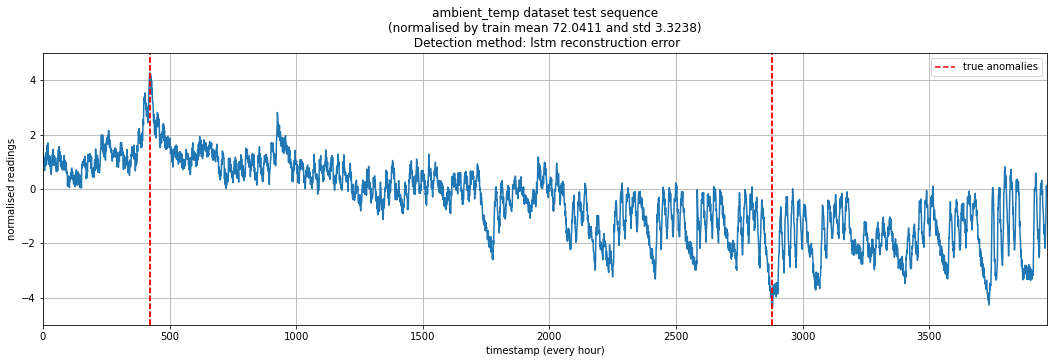

In [24]:
plot_detected_anomalies(idx_detection_augmented, 
                        interval=config['l_win']*config['l_seq']/2, 
                        dataset=dataset, 
                        result=result, 
                        detection_method='lstm reconstruction error',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)